TODO: This will be the machine learning code

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from datetime import datetime

2024-11-30 14:13:48.266647: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-30 14:13:49.077734: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-30 14:13:49.077892: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-30 14:13:49.082814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 14:13:49.502434: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-30 14:13:49.508446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [9]:
path = os.path.join(os.getcwd())
data1 = pd.read_csv(path + '/arduino_data1.csv')
data1.head()

,Time,Soil_Moisture,Light_Intensity,Pump Signal
0,2024-10-27 18:22:13.909328+00:00,300,611,OFF
1,2024-10-27 18:25:13.910349+00:00,304,536,OFF
2,2024-10-27 18:28:13.911928+00:00,304,619,OFF
3,2024-10-27 18:31:13.913328+00:00,305,616,OFF
4,2024-10-27 18:34:13.914910+00:00,305,620,OFF


In [3]:
print(data1.columns)

Index(['Time', 'Soil_Moisture', 'Light_Intensity', 'Pump Signal'], dtype='object')


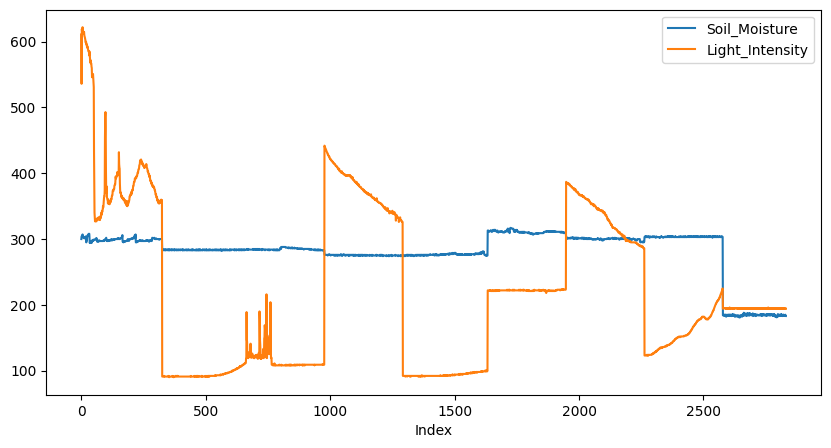

In [10]:
# data_time = pd.to_datetime(data1.pop('Time'), format='%d.%m.%Y %H:%M:%S')
time_data = [datetime.fromisoformat(t) for t in data1['Time']]
plot_cols = ['Soil_Moisture', 'Light_Intensity']
plot_features = data1[plot_cols]
# plot_features.index = data_time
# plt.figure(figsize=(10,5))
# plt.plot(time_data, data1['Soil_Moisture'])
# data1.set_index('Time', inplace=True)
data1[plot_cols].plot(figsize=(10,5))
plt.xlabel('Index')
# fig, ax = plt.subplots(1)
# ax.plot(plot_features)
# ax.set_xticklabels([])
plt.show()

In [29]:
data1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Soil_Moisture,651.0,341.010753,130.297145,208.0,211.0,319.0,479.0,515.0
Light_Intensity,651.0,410.926267,271.165520,140.0,143.0,332.0,700.5,828.0


Convert time to seconds and convert into usable signals (it is periodic and should be a signal)

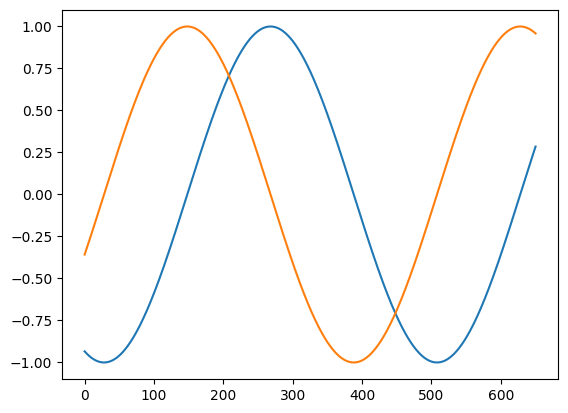

In [30]:
timestamp_s = [t.timestamp() for t in time_data]

day = 24*60*60
year = (365.2425) * day
day_sin = [np.sin(t * (2 * np.pi / day)) for t in timestamp_s]
day_cos = [np.cos(t * (2 * np.pi / day)) for t in timestamp_s]

plt.plot(day_sin)
plt.plot(day_cos)
plt.show()

In [31]:
df = data1
col_indices = {name: i for i, name in enumerate(df.columns)}
df['Pump Signal'] = [1 if i=='ON' else 0 for i in df['Pump Signal']]
df['Time'] = day_sin
df.head()

,Time,Soil_Moisture,Light_Intensity,Pump Signal
0,-0.933865,412,742,0
1,-0.938466,490,744,0
2,-0.942907,494,737,0
3,-0.947186,491,733,0
4,-0.951302,487,722,0


# Making the Dataset

In [32]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
num_features


4

Normalize the Data

In [33]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Data Window: Model makes a prediction based on a window of data

In [34]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None
                 ):
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Get the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'
        ])
    
    # Given a list of consecutive inputs, 
    # this method converts them into a window of inputs and a window of labels
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1
            )
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data, 
            targets=None, 
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,
        )
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

In [35]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['Pump Signal'])    
w1.val

<_MapDataset element_spec=(TensorSpec(shape=(None, 24, 4), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))>

# Building the Model

Predict one step into the future

In [36]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, label_columns=['Pump Signal']
)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Pump Signal']

Create a performance baseline for later comparison

In [37]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]
    
baseline = Baseline(label_index=column_indices['Pump Signal'])
baseline.compile(loss=tf.keras.losses.MeanSquaredError(), 
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])
val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(single_step_window.val, return_dict=True)
performance['Baseline'] = baseline.evaluate(single_step_window.test, return_dict=True)

3/3 [==============================] - 0s 4ms/step - loss: nan - mean_absolute_error: nan


For a 24h Prediction

In [38]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1, label_columns=['Pump Signal']
)
wide_window
print('Input shape: ', wide_window.example[0].shape)
print('Output shape: ', baseline(wide_window.example[0]).shape)

Input shape:  (32, 24, 4)
Output shape:  (32, 24, 1)


Model Design

In [39]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(), 
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])

    return history

In [40]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu')
])
history = compile_and_fit(dense, single_step_window)
val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
15/15 [==============================] - 1s 16ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
5/5 [==============================] - 0s 3ms/step - loss: nan - mean_absolute_error: nan


In [41]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 4)
Output shape: (32, 24, 1)


In [42]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
14/14 [==============================] - 6s 117ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/20
14/14 [==============================] - 0s 30ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
